# Calculate velocity potential for ERA5

## 1. Load modules

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [2]:
from windspharm.xarray import VectorWind
from windspharm.examples import example_data_path

In [3]:
years = np.arange(1980, 2015)
nyr = len(years)

## 2. Read ERA5 data, calculate velocity potential, and save the results

In [4]:
idir = '~/_scratch/ERA5/daily/'
odir = '/home/jjung45/_scratch/ERA5/daily/vp200/'

In [5]:
n = 0
for year in years:
    u_path = idir+'u200/'+f'u200_{year}.nc'
    v_path = idir+'v200/'+f'v200_{year}.nc'
    
    ds_u = xr.open_dataset(u_path)
    ds_v = xr.open_dataset(v_path)
    ds_u = ds_u.rename({"day":"time"})
    ds_v = ds_v.rename({"day":"time"})
    
    u0 = ds_u['u'].sel(pressure_level=200.0)
    v0 = ds_v['v'].sel(pressure_level=200.0)
    u = u0[:,::-1,:]
    v = v0[:,::-1,:]
    del u0, v0
    
    lat0 = ds_u['lat']  
    lat = lat0[::-1]
    del lat0
    lon = ds_u['lon']
    nlat = len(lat)
    nlon = len(lon)
    
    time = ds_u['time']
    ntime = len(time)
    
    nn = 0
    vp_array = np.empty((ntime,nlat,nlon),dtype=np.float32)
    for time_idx in range(ntime):
        uwnd = u[nn,:,:]
        vwnd = v[nn,:,:]
        # velocity potential.
        w = VectorWind(uwnd, vwnd)
        # Compute the streamfunction and velocity potential.
        sf, vp = w.sfvp()
        # print(np.shape(vp))
        
        vp_array[nn,:,:] = vp
        #print(nn)
        del vp
        nn += 1
    vp_array = xr.DataArray(vp_array, dims=["time", "lat", "lon"],
                                coords={'time':time,
                                        'lat': lat,
                                        'lon': lon}, name = 'vp200')
    vp_array.to_netcdf(odir+f'vp200_{year}01.nc')
    print(odir+f'vp200_{year}01.nc')
    del ds_u, ds_v
    n += 1

/tmp/ipykernel_286284/3545291149.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  vp_array[nn,:,:] = vp


/home/jjung45/_scratch/ERA5/daily/vp200/vp200_198001.nc


## 3. Plotting to check the value of the velocity potential

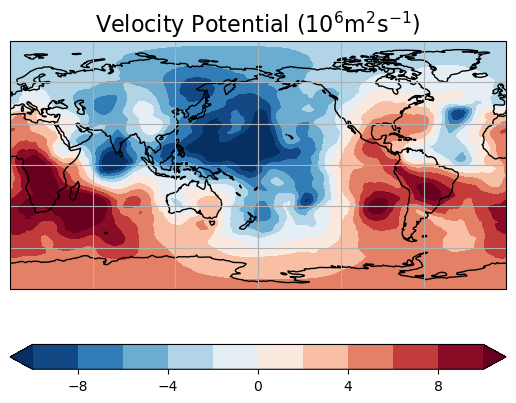

In [6]:
# Plotting to check the value of the velocity potential
plt.figure()
ax2 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
clevs = [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]
fill_vp = ax2.contourf(lon, lat, vp_array[0,:,:] * 1e-06, clevs,
                       transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r,
                       extend='both')
ax2.coastlines()
ax2.gridlines()
plt.colorbar(fill_vp, orientation='horizontal')
plt.title('Velocity Potential ($10^6$m$^2$s$^{-1}$)', fontsize=16)
plt.show()